In [1]:
%matplotlib inline

# Version 1 du modèle prédictif

Dans ce notebook, nous allons élaborer un premier modèle, très simple, qui prédit l'issue d'un match. On utilisera le concept de 'Probabilistic Programming', disponible à travers le package pymc3.

On commence par importer les données dont on aura besoin.

In [2]:
import pandas as pd

In [3]:
league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0)

On retire les colonnes suivantes : B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA car je ne sais pas à quoi elles correspondent, il n'y a aucune indication (ce sont peu être des cotes ??)

In [4]:
match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

Dans cette version, on ne va pas s'interesser aux joeurs, on va rester au niveau de granularité supérieur, cad les équipes

In [5]:
match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

De plus, on ne va pas non plus encore s'interesser aux corner, possession, tirs cadrés, etc. On les supprime aussi

In [6]:
match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

Enfin, on va supprimer les variables suivantes qui n'ont pour le moment pas d'intêret :

In [7]:
match.drop(['country_id', 'season', 'stage', 'date', 'match_api_id'],
           axis=1, inplace=True)

Enfin, on va rajouter les colonnes contenant le nom complet des équipes afin de les identifier plus facilement

In [8]:
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

In [9]:
match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

In [10]:
match.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name
0,1,1,9987,9993,1,1,KRC Genk,Beerschot AC
1,483,1,9987,9993,1,1,KRC Genk,Beerschot AC
2,524,1,9987,9993,2,1,KRC Genk,Beerschot AC
3,759,1,9987,9993,3,1,KRC Genk,Beerschot AC
4,1014,1,9987,9993,3,0,KRC Genk,Beerschot AC


On va maintenant se limiter à la ligue 1 française dans un premier temps

In [11]:
match_ligue_1 = match[match.league_id == 1729]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

34


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [12]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [13]:
teams

,team,i
0,Manchester United,0
1,Arsenal,1
2,Sunderland,2
3,West Ham United,3
4,Aston Villa,4
5,Everton,5
6,Middlesbrough,6
7,Bolton Wanderers,7
8,Hull City,8
9,Chelsea,9


In [14]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [15]:
match_ligue_1.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,i_home,i_away
0,1729,1729,10260,10261,1,1,Manchester United,Newcastle United,0,33
1,2494,1729,10260,10261,3,0,Manchester United,Newcastle United,0,33
2,2913,1729,10260,10261,1,1,Manchester United,Newcastle United,0,33
3,3353,1729,10260,10261,4,3,Manchester United,Newcastle United,0,33
4,3693,1729,10260,10261,0,1,Manchester United,Newcastle United,0,33


On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [16]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match_ligue_1.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_ligue_1.home_team_goal.values[:train_size]
observed_away_goals = match_ligue_1.away_team_goal.values[:train_size]

home_team = match_ligue_1.i_home.values[:train_size]
away_team = match_ligue_1.i_away.values[:train_size]

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation ![title](illustrations/V1.png)

In [17]:
import theano
import numpy as np

model_input = theano.shared(np.array([home_team, away_team]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [18]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # Paramètres spécifiques à chaque équipe  
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)
    
    # Paramètre lié aux conditions du match
    coeff_home = pm.Normal("coeff_home", mu=0, sd=1, shape=1)
    
    # et un intercept
    intercept = pm.Normal("intercept", mu=0, sd=1, shape=1)
    
    home_theta  = pm.math.exp(intercept + coeff_home + attaque[model_input[0]] - defense[model_input[1]])
    away_theta  = pm.math.exp(intercept + attaque[model_input[1]] - defense[model_input[0]])

    # likelihood of observed data 
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -5,867.6: 100%|██████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 592.38it/s]
Finished [100%]: Average ELBO = -5,720.8
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:45<00:00,  2.47it/s]


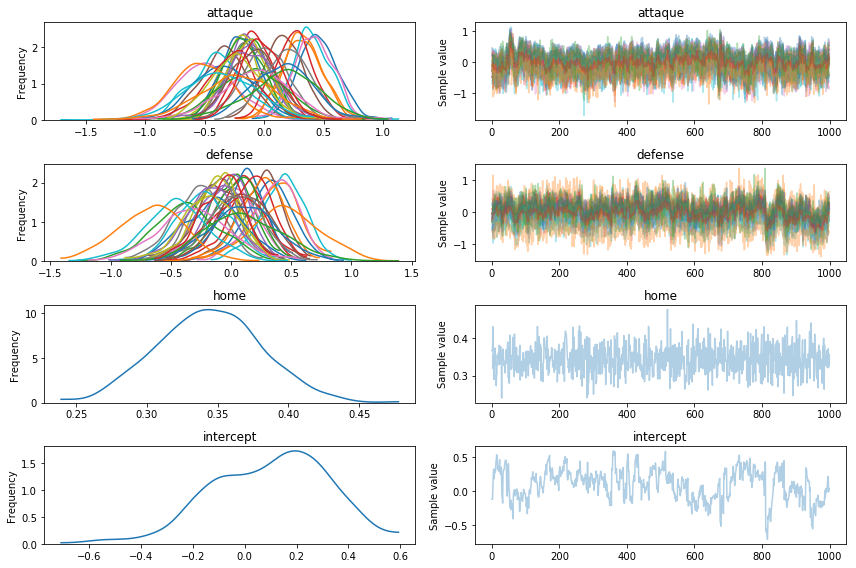

In [19]:
with model:
    trace = pm.sample(1000, n_init=10000)

    pm.traceplot(trace)

La phase de sampling étant terminé, on va afficher pour chaque équipe la ditribution à posteriori des paramètres d'attaque et de défense sous forme de forestplot : 

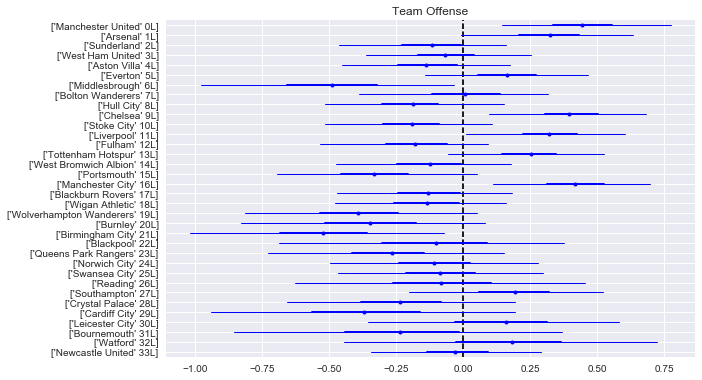

In [49]:
pm.forestplot(trace[100:], varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=1)

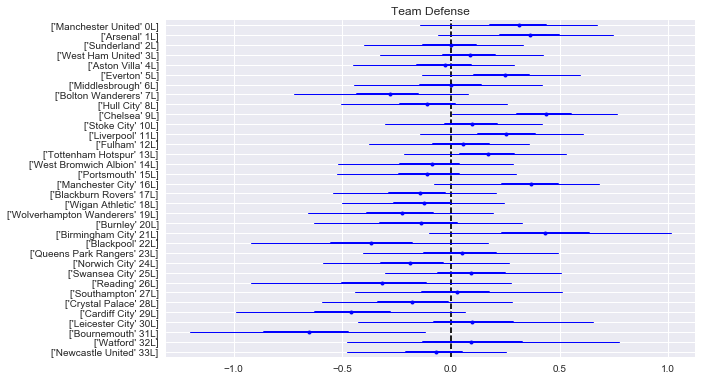

In [50]:
pm.forestplot(trace[100:], varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=1)

Les résultats semblent cohérents (le trio de tête est PSG - OL - OM), passons à la prédiction d'un nouveau match.

# Prédiction de l'issue d'un match

On cherche à prédire l'issue d'un match. Pour cela, on change les paramètres d'entrée, et on relance notre modèle : (ici : PSG contre Grenoble (indice 18 vs indice 17), on s'attend à voir le PSG gagner..

In [22]:
model_input.set_value(np.array([[18],[17]]))

Et on sample depuis notre modèle avec les nouvelles entrées

In [23]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:45<00:00,  7.47it/s]


On fait un peu de mise en forme des résultats afin de pouvoir les exploiter simplement

In [24]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']

In [25]:
prediction_score.head()

,home_points,away_points
0,5,2
1,5,3
2,1,0
3,0,1
4,1,1


In [26]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

prediction_score['vainqueur'] = prediction_score.apply(vainqueur, axis=1)

In [27]:
prediction_score.head()

,home_points,away_points,vainqueur
0,5,2,H
1,5,3,H
2,1,0,H
3,0,1,A
4,1,1,N


In [28]:
prediction_score.vainqueur.value_counts()

H    501
A    259
N    240
Name: vainqueur, dtype: int64

On calcule les probabilités associées

In [29]:
100 * prediction_score.vainqueur.value_counts() / prediction_score.vainqueur.count()

H    50.1
A    25.9
N    24.0
Name: vainqueur, dtype: float64

Le PSG (home ici) a 77.9% de chances de l'emporter. 

On va enfin calculer le résultat le plus probable (les buts encaissés pour chacune des équipes). Une rapide visualisation nous montre que le résultat le plus probable est 2-0. Vérifions le :

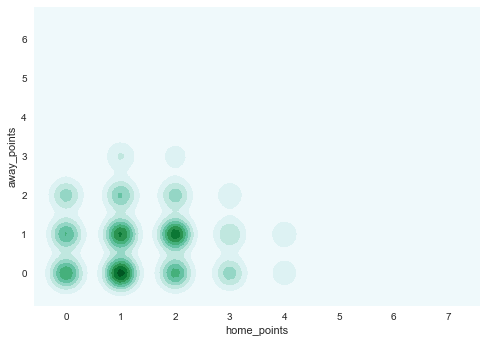

In [30]:
import seaborn
seaborn.kdeplot(data=prediction_score.home_points, data2=prediction_score.away_points, shade=True)

In [31]:
prediction_score.groupby(["home_points", "away_points"]).size()

home_points  away_points
0            0               82
             1               70
             2               48
             3               13
             4                5
             5                1
1            0              117
             1               99
             2               57
             3               29
             4                5
             5                1
             6                1
2            0               75
             1              106
             2               49
             3               21
             4                5
             6                1
3            0               49
             1               42
             2               24
             3                8
             4                2
4            0               24
             1               25
             2                7
             4                2
5            0                6
             1                8
             2 

In [32]:
prediction_score.groupby(["home_points", "away_points"]).size().idxmax()

(1, 0)

In [33]:
100. * prediction_score.groupby(["home_points", "away_points"]).size().max() / prediction_score.vainqueur.count()

11.699999999999999

Conclusion, le résultat est cohérent, on s'attend à ce que le PSG l'emporte (77.9% de chances) avec un score de 2-0 (17.4 % de chances)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation :

In [34]:
observed_home_goals = match_ligue_1.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match_ligue_1.away_team_goal.values[train_size+1:CV_size]

home_team = match_ligue_1.i_home.values[train_size+1:CV_size]
away_team = match_ligue_1.i_away.values[train_size+1:CV_size]

Et on assigne ces nouveaux individus comme entrée et sortie de notre modèle

In [35]:
model_input.set_value(np.array([home_team,away_team], dtype=np.int32))

Et on tire 10000 réalisations pour chacun des matchs

In [36]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:49<00:00,  7.42it/s]


L'échantillon est désormais créé, on va maintenant comparer nos prédictions avec la réalité :

In [37]:
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

On crée un dataframe pour chaque match (chacun contenant 10000 simulations)

In [38]:
prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']

Pour chaque dataframe, on détermine l'équipe qui gagne

In [39]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

In [40]:
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 

On ajoute aussi le score le plus probable d'après nos simulations :

In [41]:
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

On met en forme aussi les vrais résultats (ie. les observations)

In [42]:
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals)  

In [43]:
vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

On a enfin notre dataframe contenant les observations et les prédictions (gagnant + score) match par match :

In [44]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,3,2,H,H,1,1
1,2,1,H,H,1,1
2,3,0,H,H,1,1
3,2,2,N,A,1,2
4,1,3,A,A,1,1
5,0,2,A,A,1,1
6,1,3,A,A,0,2
7,0,2,A,A,1,1
8,0,2,A,A,1,1
9,1,1,N,A,1,1


On calcule notre score :

In [45]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.56507413509060955

Ce n'est pas si mal pour un premier modèle, extrèmement simple pour le moment...

In [53]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.454695
A    0.303130
N    0.242175
Name: vainqueur, dtype: float64

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [48]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.11037891268533773

On a prédit le bon score dans 14.5% des cas.

Par la suite, on améliorera le modèle selon 3 axes :
- les buts étant des évênements rares, ils sont soumis à une grande variabilité et peuvent donc être une métrique trompeuse. Il va donc falloir "l'augmenter" avec d'autres évênements moins rares, mais quasiment tout autant important : le nombre de tirs cadrés, non cadrés, corner, de pénaltis, etc.
- mieux charactériser les paramètres latents d'une équipe. On a ici résumé l'information disponible à un score d'attaque et un score de défense, mais il y en a certainement d'autres : la possession moyenne de balle par exemple ? ...
- mieux charactériser la situation du match, indépendement des performances d'une équipe : le fait de jouer à domicile a été pris en compte ici, mais on peut penser à d'autres choses, tels que le temps de repos depuis le dernier match, etc.
- prendre en compte l'évolution du style de jeu au cours des années (cf le notebook sur les buts vs loi de poisson)

Eventuellement plus tard modéliser au niveau du joueur